In [1]:
using LinearAlgebra
using Statistics
using Random
using MLJ, MLJLinearModels
using StructuredOptimization
using HyperTuning

In [52]:
using Pkg
Pkg.activate(".")
include("src/qsrfe.jl")

  Activating project at `~/qsrfe`


Main.qsrfe

In [4]:
# SETUP

experiment_name = "boston1"

homedir = "/home/tobias-grasberger/qsrfe/"
outdir = homedir * "out/$experiment_name/"

if !isdir(outdir)
    mkpath(outdir)
end

In [5]:
# utils

function print_res(y, yhat)
    println("MSE: ", mean((y .- yhat).^2))
    println("MAE: ", mean(abs.(y .- yhat)))
    println("rel l2: ", norm(y - yhat) / norm(y))
    println("rsq: ", 1 - sum((y - yhat).^2) / sum((y .- mean(y)).^2))
end

function get_res_dict(y, yhat)
    return Dict(
        "mse" => mean((y .- yhat).^2),
        "mae" => mean(abs.(y .- yhat)),
        "rel_l2" => norm(y - yhat) / norm(y),
        "rsq" => 1 - sum((y - yhat).^2) / sum((y .- mean(y)).^2)
    )
end

function get_res(y,yhat)
    return [
        mean((y .- yhat).^2),
        mean(abs.(y .- yhat)),
        norm(y - yhat) / norm(y),
        1 - sum((y - yhat).^2) / sum((y .- mean(y)).^2)
    ]
end

#method, n_levels, penalty, x_hat
function add_to_dict!(dict, method, n_levels, content)
    if !haskey(dict, method)
        dict[method] = Dict{Integer,Union{Dict{String,Float64},Float64}}()
    end
    
    dict[method][n_levels] = content
end

add_to_dict! (generic function with 1 method)

In [6]:
# method, n_levels, (penalty, x_hat)
results = Dict{String,Dict{Integer, Dict{String,Float64}}}()
lambdas = Dict{String,Dict{Integer, Float64}}()

Dict{String, Dict{Integer, Float64}}()

# Dataset / Forward

In [ ]:
# we end with xtrain, ytrain, xtest, ytest

In [7]:
# Boston
X, Y = @load_boston
(xtrain, xtest), (ytrain, ytest) = qsrfe.load_dataset(X,Y;normalize=true,partitioning=0.8,rng=1234);
indexmaptrain = ytrain .<= 47
indexmaptest = ytest .<= 47
(xtrain, xtest), (ytrain, ytest) = (xtrain[indexmaptrain,:], xtest[indexmaptest,:]), (ytrain[indexmaptrain], ytest[indexmaptest]);
# data stats
println("Size of training set: ", size(xtrain))
println("Size of test set: ", size(xtest))

Size of training set: (389, 12)
Size of test set: (98, 12)


In [28]:
# construct test dataset
Random.seed!(1234)
n1, n2 = 100, 1000

xtrain = randn(10, n1)
xtest = randn(10, n2)

function f(x)
    s = 0.0
    for i in 1:9
        s += exp(- (x[i])^2) / (1 + (x[i+1])^2)
    end
    return (1/10) * sum([x[i] for i in 1:10]) 
end

ytrain = [f(xtrain[:,i]) for i in 1:n1]
ytest = [f(xtest[:,i]) for i in 1:n2];

print_res (generic function with 1 method)

# Setup Model

In [11]:
N_levels = [2^6,2^7,2^8,2^9,2^10,2^11,2^12,2^13,2^14,2^15]

10-element Vector{Int64}:
    64
   128
   256
   512
  1024
  2048
  4096
  8192
 16384
 32768

In [53]:
function gen_weights!(model,d)
    ω, ζ = qsrfe.gen_weights(model.N,d,model.q,model.σ2)
    model.ω = ω
    model.ζ = ζ
    return nothing
end

function generate_A(model, X, quantizer::Union{Nothing, qsrfe.Quantizer}=nothing)
    A = qsrfe.compute_featuremap(X,model.ω, model.func,model.ζ)
    if !isnothing(quantizer)
        A = qsrfe.quantize(quantizer,A)
        if quantizer.condense
            A = qsrfe.condense(quantizer,A)
        end
    end
    if model.intercept
        A = hcat(ones(size(A,1)), A)
    end
    return A
end


generate_A (generic function with 4 methods)

In [102]:
function generate_A(model, X, quantizer::Nothing=nothing)
    A = qsrfe.compute_featuremap(X,model.ω, model.func,model.ζ)
    if !isnothing(quantizer)
        A = qsrfe.quantize(quantizer,A)
        if quantizer.condense
            A = qsrfe.condense(quantizer,A)
        end
    end
    if model.intercept
        A = hcat(ones(size(A,1)), A)
    end
    return A
end

generate_A (generic function with 5 methods)

In [13]:
function normalization_operator(A::AbstractArray)
    """
        This function returns the normalization operator for the dictionary A.
            Multiply from the right to normalize columns of A.
        Usage:
        A_normalized = A * normalization_operator(A) 
    """
    return diagm(1 ./ vec(sqrt.(sum(A .^2, dims = 1))))
end

normalization_operator (generic function with 1 method)

## what exactly do i want

-> decide on model
srfe, quant, sigma

for each N

for smaller N use Hyperopt

find best hyperparameter over array
train 5 times with this hyperparameter
save avg results in dict with method name

In [103]:
# set model
N_levels = [2^14] #
method = "SRFE"

for N in N_levels

    print("N: ", N)
    model = qsrfe.srfeRegressor(N=N, σ2=11.0,intercept=false) #lambda does not matter here

    #setup
    gen_weights!(model,size(xtrain,2))
    A = generate_A(model, xtrain) #generate_A(model, xtrain, quant)

    # function objective(trial)
    #     @unpack λ = trial
        
    #     #fitting
    #     c = StructuredOptimization.Variable(size(A,2));
    #     @minimize ls( A * c - (ytrain) ) +  λ * norm(c, 1) ;
    #     eta = norm(ytrain - A * ~c)

    #     #evaluating
    #     ytesthat = generate_A(model, xtest) * ~c

    #     return qsrfe.mse(ytest,ytesthat)
    # end

    # scenario = Scenario(λ = (0.00001..0.01),
    #                         max_trials = 200);

    # HyperTuning.optimize(objective, scenario)
    # @unpack λ = scenario

    λ = 0.0032

    #add_to_dict!(lambdas, method, N, λ)
    println(", λ: ", λ)
    # trials 
    trials = 10
    res = zeros(Float64, 4)
    model = qsrfe.srfeRegressor(N=N,λ=λ, σ2=11.0,intercept=false)

    for i in 1:trials

        gen_weights!(model,size(xtrain,2))
        A = generate_A(model, xtrain) #generate_A(model, xtrain, quant)

        #fitting
        c = StructuredOptimization.Variable(size(A,2));
        @minimize ls( A * c - (ytrain) ) +  λ * norm(c, 1) ;
        eta = norm(ytrain - A * ~c)

        #evaluating
        ytesthat = generate_A(model, xtest) * ~c

        #print_res(ytest, ytesthat)
        res = res + get_res(ytest, ytesthat) * (1/trials)
    end

    add_to_dict!(results2, method, N, Dict(zip(["mse", "mae", "rel_l2", "rsq"],res)))
end



N: 16384, λ: 0.0032


In [135]:
lambdas

Dict{String, Dict{Integer, Float64}} with 3 entries:
  "SRFE3" => Dict(64=>0.00486799, 16384=>0.0032, 1024=>0.00498864, 2048=>0.0057…
  "SRFE"  => Dict(64=>0.0032, 32768=>0.0032, 1024=>0.0032, 2048=>0.0032, 8192=>…
  "SRFE2" => Dict(64=>0.0012, 32768=>0.0012, 16384=>0.0012, 1024=>0.0012, 2048=…

In [151]:
using JLD2
save_object(outdir * "lambdas.jld2", lambdas)
save_object(outdir * "results.jld2", results)

In [35]:
using Profile

In [75]:
model = qsrfe.srfeRegressor(N=2^15,λ=1.0, σ2=11.0,intercept=false)
quant = qsrfe.βQ(K= 2, limit = 1, β= 1.5, λ= 32, condense= true)
gen_weights!(model,size(xtrain,2))
A = collect(generate_A(model, xtrain, quant))

389×1024 Matrix{Float64}:
 -0.00467454   0.0340907    0.0397378   …  -0.0125726    0.0282008
  0.00415938   0.0443515    0.0581622       0.00603766  -0.0277777
  0.0114423    0.0475037   -0.00070345     -0.0230057    0.0210988
  0.00275321   0.0376271    0.0282491      -0.0364108    0.00534953
  0.0246552    0.0562057    0.0395189      -0.0160015    0.0596278
  0.0260523    0.00699228   0.0388047   …  -0.0151944    0.0496467
  0.0214176    0.0555512    0.0601912      -0.0248115    0.00457833
 -0.00945891   0.0290908    0.0207506      -0.0357474    0.000974289
  0.0155459    0.0505082    0.0503853      -0.0304913    0.0215231
  0.0273773    0.0558026    0.0295208      -0.0281343    0.0366971
  ⋮                                     ⋱               
  0.00390849   0.0296051    0.0370694   …  -0.0132019    0.0276699
  0.0327298    0.0128753    0.0388163      -0.0175409    0.0500901
  0.0110185    0.0502232    0.0400746      -0.00267133   0.0417596
 -0.0177165    0.0101476    0.0126974     

In [76]:
# set model
N_levels = [2^6,2^7,2^8,2^9,2^10,2^11,2^12,2^13, 2^14,2^15] #2^12,
method = "βQSRFE 1-bit"

quant = qsrfe.βQ(K= 2, limit = 1, β= 1.5, λ= 32, condense= true)

for N in N_levels

    print("N: ", N)
    model = qsrfe.srfeRegressor(N=N, σ2=11.0,intercept=false) #lambda does not matter here

    #setup
    gen_weights!(model,size(xtrain,2))
    A = collect(generate_A(model, xtrain, quant)) #generate_A(model, xtrain, quant)

    function objective(trial)
        @unpack λ = trial
        
        #fitting
        c = StructuredOptimization.Variable(size(A,2));
        @minimize ls( A * c - (ytrain) ) +  λ * norm(c, 1) ;
        eta = norm(ytrain - A * ~c)

        #evaluating
        ytesthat = generate_A(model, xtest, quant) * ~c

        return qsrfe.mse(ytest,ytesthat)
    end

    scenario = Scenario(λ = (0.0000001..0.1),
                            max_trials = 200);

    HyperTuning.optimize(objective, scenario)
    @unpack λ = scenario

    #λ = 0.008

    add_to_dict!(lambdas, method, N, λ)
    println(", λ: ", λ)
    # trials 
    trials = 10
    res = zeros(Float64, 4)
    model = qsrfe.srfeRegressor(N=N,λ=λ, σ2=11.0,intercept=false)

    for i in 1:trials

        gen_weights!(model,size(xtrain,2))
        A = collect(generate_A(model, xtrain, quant)) #generate_A(model, xtrain, quant)

        #fitting
        c = StructuredOptimization.Variable(size(A,2));
        @minimize ls( A * c - (ytrain) ) +  λ * norm(c, 1) ;
        eta = norm(ytrain - A * ~c)

        #evaluating
        ytesthat = generate_A(model, xtest, quant) * ~c

        #print_res(ytest, ytesthat)
        res = res + get_res(ytest, ytesthat) * (1/trials)
    end

    add_to_dict!(results, method, N, Dict(zip(["mse", "mae", "rel_l2", "rsq"],res)))
end



N: 64, λ: 1.0e-7
N: 128, λ: 1.0e-7
N: 256, λ: 0.1
N: 512, λ: 1.0e-7
N: 1024, λ: 1.0e-7
N: 2048, λ: 0.1
N: 4096, λ: 0.03452192338476578
N: 8192, λ: 0.05201845086231298
N: 16384, λ: 0.031622012392568934
N: 32768, λ: 0.01782143265029456


In [87]:
results

Dict{String, Dict{Integer, Dict{String, Float64}}} with 1 entry:
  "βQSRFE 1-bit" => Dict(64=>Dict("mse"=>210.757, "rsq"=>-2.2179, "mae"=>10.645…

In [89]:
using JLD2

In [90]:
results2 = load_object(outdir * "results.jld2")

Dict{String, Dict{Integer, Dict{String, Float64}}} with 3 entries:
  "SRFE2" => Dict(64=>Dict("mse"=>12.4281, "rsq"=>0.810243, "mae"=>2.56033, "re…
  "SRFE"  => Dict(64=>Dict("mse"=>12.2807, "rsq"=>0.812494, "mae"=>2.45185, "re…
  "SRFE3" => Dict(64=>Dict("mse"=>11.6037, "rsq"=>0.822831, "mae"=>2.47393, "re…

# Plotting

In [80]:
using CairoMakie
using Makie

In [90]:
results["SRFE"]

Dict{Integer, Dict{String, Float64}} with 9 entries:
  64    => Dict("mse"=>12.2807, "rsq"=>0.812494, "mae"=>2.45185, "rel_l2"=>0.14…
  32768 => Dict("mse"=>9.33192, "rsq"=>0.857517, "mae"=>2.18882, "rel_l2"=>0.12…
  1024  => Dict("mse"=>10.001, "rsq"=>0.847301, "mae"=>2.26031, "rel_l2"=>0.129…
  2048  => Dict("mse"=>9.15306, "rsq"=>0.860248, "mae"=>2.17719, "rel_l2"=>0.12…
  8192  => Dict("mse"=>9.26024, "rsq"=>0.858612, "mae"=>2.1965, "rel_l2"=>0.125…
  512   => Dict("mse"=>9.53601, "rsq"=>0.854401, "mae"=>2.22533, "rel_l2"=>0.12…
  128   => Dict("mse"=>9.30379, "rsq"=>0.857947, "mae"=>2.1905, "rel_l2"=>0.125…
  256   => Dict("mse"=>8.8391, "rsq"=>0.865042, "mae"=>2.16632, "rel_l2"=>0.122…
  4096  => Dict("mse"=>9.53222, "rsq"=>0.854459, "mae"=>2.20906, "rel_l2"=>0.12…

In [136]:
for method in methods
    mse_values = [results[method][N]["mse"] for N in N_values]
    println("mse_values: ", mse_values)
end

mse_values: [12.28073000841327, 9.303790992040105, 8.83910379107847, 9.536009813776698, 10.001004038141284, 9.153055653206028, 9.532218029718543, 9.260235225391884, 9.331924010876724]
mse_values: [12.428109057173653, 9.95266802789883, 10.050846070803917, 9.051598490032866, 9.064003879720321, 9.644211137565314, 9.215251078799911, 9.115570459805745, 9.208595505500137]


In [105]:
results2["SRFE"]

Dict{Integer, Dict{String, Float64}} with 10 entries:
  64    => Dict("mse"=>12.2807, "rsq"=>0.812494, "mae"=>2.45185, "rel_l2"=>0.14…
  4096  => Dict("mse"=>9.53222, "rsq"=>0.854459, "mae"=>2.20906, "rel_l2"=>0.12…
  16384 => Dict("mse"=>9.31836, "rsq"=>0.857724, "mae"=>2.19892, "rel_l2"=>0.12…
  1024  => Dict("mse"=>10.001, "rsq"=>0.847301, "mae"=>2.26031, "rel_l2"=>0.129…
  2048  => Dict("mse"=>9.15306, "rsq"=>0.860248, "mae"=>2.17719, "rel_l2"=>0.12…
  8192  => Dict("mse"=>9.26024, "rsq"=>0.858612, "mae"=>2.1965, "rel_l2"=>0.125…
  512   => Dict("mse"=>9.53601, "rsq"=>0.854401, "mae"=>2.22533, "rel_l2"=>0.12…
  128   => Dict("mse"=>9.30379, "rsq"=>0.857947, "mae"=>2.1905, "rel_l2"=>0.125…
  256   => Dict("mse"=>8.8391, "rsq"=>0.865042, "mae"=>2.16632, "rel_l2"=>0.122…
  32768 => Dict("mse"=>9.33192, "rsq"=>0.857517, "mae"=>2.18882, "rel_l2"=>0.12…

In [110]:
input["SRFE"]

Dict{Integer, Dict{String, Float64}} with 10 entries:
  64    => Dict("mse"=>12.2807, "rsq"=>0.812494, "mae"=>2.45185, "rel_l2"=>0.14…
  4096  => Dict("mse"=>9.53222, "rsq"=>0.854459, "mae"=>2.20906, "rel_l2"=>0.12…
  16384 => Dict("mse"=>9.31836, "rsq"=>0.857724, "mae"=>2.19892, "rel_l2"=>0.12…
  1024  => Dict("mse"=>10.001, "rsq"=>0.847301, "mae"=>2.26031, "rel_l2"=>0.129…
  2048  => Dict("mse"=>9.15306, "rsq"=>0.860248, "mae"=>2.17719, "rel_l2"=>0.12…
  8192  => Dict("mse"=>9.26024, "rsq"=>0.858612, "mae"=>2.1965, "rel_l2"=>0.125…
  512   => Dict("mse"=>9.53601, "rsq"=>0.854401, "mae"=>2.22533, "rel_l2"=>0.12…
  128   => Dict("mse"=>9.30379, "rsq"=>0.857947, "mae"=>2.1905, "rel_l2"=>0.125…
  256   => Dict("mse"=>8.8391, "rsq"=>0.865042, "mae"=>2.16632, "rel_l2"=>0.122…
  32768 => Dict("mse"=>9.33192, "rsq"=>0.857517, "mae"=>2.18882, "rel_l2"=>0.12…

In [114]:
N_values = [2^6,2^7,2^8,2^9,2^10,2^11,2^12,2^13, 2^14,2^15] #2^12,

10-element Vector{Int64}:
    64
   128
   256
   512
  1024
  2048
  4096
  8192
 16384
 32768

In [117]:
results

Dict{String, Dict{Integer, Dict{String, Float64}}} with 1 entry:
  "βQSRFE 1-bit" => Dict(64=>Dict("mse"=>210.757, "rsq"=>-2.2179, "mae"=>10.645…

In [120]:
results3 = merge(results, results2)

Dict{String, Dict{Integer, Dict{String, Float64}}} with 4 entries:
  "SRFE3"        => Dict(64=>Dict("mse"=>11.6037, "rsq"=>0.822831, "mae"=>2.473…
  "βQSRFE 1-bit" => Dict(64=>Dict("mse"=>210.757, "rsq"=>-2.2179, "mae"=>10.645…
  "SRFE"         => Dict(64=>Dict("mse"=>12.2807, "rsq"=>0.812494, "mae"=>2.451…
  "SRFE2"        => Dict(64=>Dict("mse"=>12.4281, "rsq"=>0.810243, "mae"=>2.560…

In [122]:
N_levels = [2^6,2^7,2^8,2^9,2^10,2^11,2^12,2^13, 2^14,2^15] #2^12,

10-element Vector{Int64}:
    64
   128
   256
   512
  1024
  2048
  4096
  8192
 16384
 32768

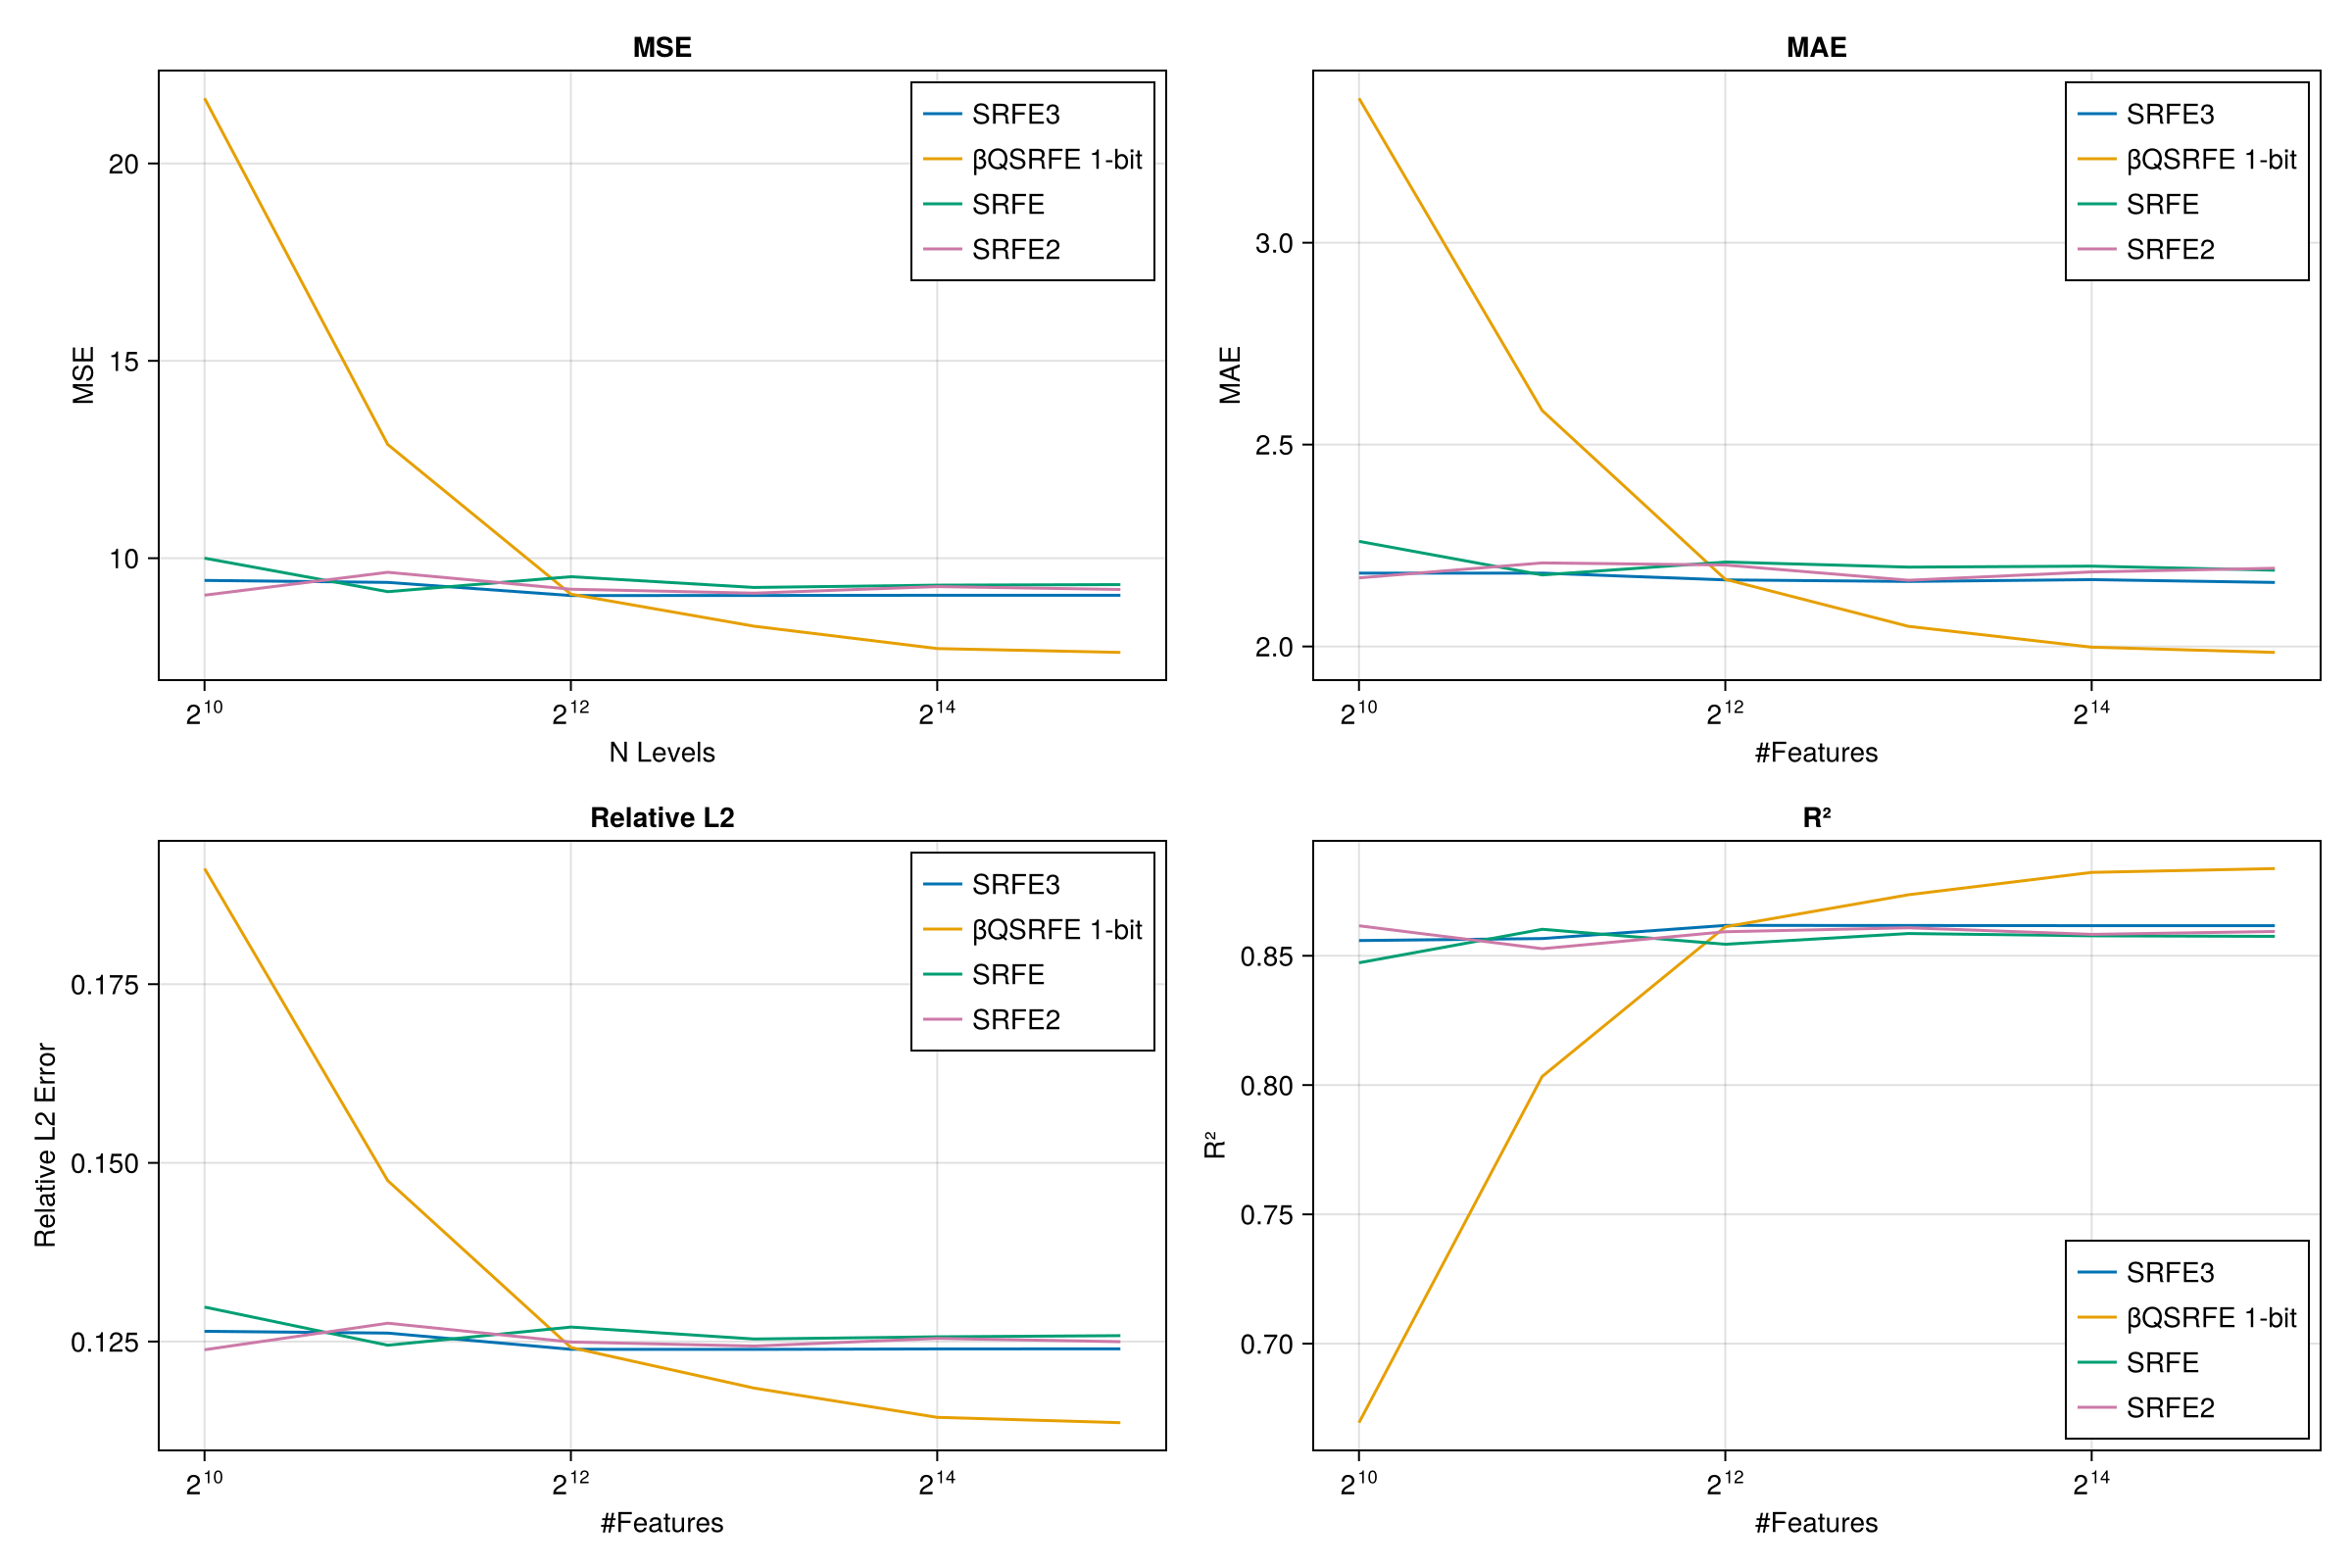

In [123]:
input = results3

# Extract data from the results dictionary
methods = keys(input)
N_values = N_levels[5:end]

# Create the main figure
f = CairoMakie.Figure(size = (1200, 800))

# Create axes for each metric
ax = Axis(f[1, 1], 
    title = "MSE",
    xlabel = "N Levels",
    ylabel = "MSE",
    xscale = log2
    )

ax2 = Axis(f[1, 2], 
    title = "MAE",
    xlabel = "#Features",
    ylabel = "MAE",
    xscale = log2
    )

ax3 = Axis(f[2, 1], 
    title = "Relative L2",
    xlabel = "#Features",
    ylabel = "Relative L2 Error",
    xscale = log2
    )

ax4 = Axis(f[2, 2], 
    title = "R²",
    xlabel = "#Features",
    ylabel = "R²",
    xscale = log2
    )

# Plot MSE for each method
for method in methods
    mse_values = [input[method][N]["mse"] for N in N_values if haskey(input[method], N)]
    lines!(ax, N_values, mse_values, label = method)
end

# Plot MAE, Relative L2, and R² for each method
for method in methods
    mae_values = [input[method][N]["mae"] for N in N_values if haskey(input[method], N)]
    rel_l2_values = [input[method][N]["rel_l2"] for N in N_values if haskey(input[method], N)]
    rsq_values = [input[method][N]["rsq"] for N in N_values if haskey(input[method], N)]
    
    lines!(ax2, N_values, mae_values, label = method)
    lines!(ax3, N_values, rel_l2_values, label = method)
    lines!(ax4, N_values, rsq_values, label = method)
end

# Add legends to all axes
axislegend(ax, position = :rt)
axislegend(ax2, position = :rt)
axislegend(ax3, position = :rt)
axislegend(ax4, position = :rb)



# Adjust the figure layout
f[1, 1] = ax
f[1, 2] = ax2
f[2, 1] = ax3
f[2, 2] = ax4

# Return the figure
f


In [124]:
save(outdir * "results_qs1.svg",f)

CairoMakie.Screen{SVG}


In [126]:
save_object(outdir * "results.jld2", results)  
save_object(outdir * "lambdas.jld2", lambdas)